In [2]:
# Cargamos librerías
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

In [5]:
# Cargamos base de datos
df = pd.read_csv('DailyDelhiClimateTest.csv', parse_dates=['date'])
df.set_index('date', inplace=True)

In [6]:
# Seleccionar las columnas que vamos a usar
variables = ['meantemp', 'humidity', 'wind_speed', 'meanpressure']
df = df[variables]

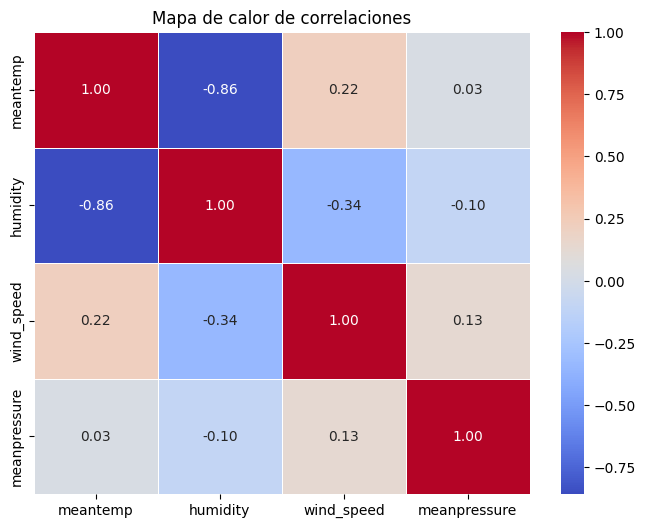

In [8]:
# Mapa de correlación
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Calcular la matriz de correlación
corr_matrix = df.corr()

# Crear el heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Título del gráfico
plt.title("Mapa de calor de correlaciones")

# Mostrar el gráfico
plt.show()

In [10]:
# Limpiar los datos
df.replace(['---', '', ' ', 'NaN'], np.nan, inplace=True)
imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=variables, index=df.index)

In [11]:
# Escalar los datos entre 0 y 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_imputed)

In [12]:
# Crear secuencias de tiempo
def create_dataset(dataset, look_back=60):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), :])
        Y.append(dataset[i + look_back, 0])  # Predecimos meantemp
    return np.array(X), np.array(Y)

In [13]:
# División 80% entrenamiento, 20% test
train_size = int(len(scaled_data) * 0.8)  # 91
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - 60:]

In [14]:
# Crear datasets de entrenamiento y prueba
look_back = 60
X_train, y_train = create_dataset(train_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)

In [15]:
# Modelo LSTM
model = Sequential([
    LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(100, return_sequences=False),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 100)             │          42,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,501 (478.52 KB)

 Trainable params: 122,501 (478.52 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Entrenamiento
model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - loss: 0.2636
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.0554
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.0829
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.0286
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.0419
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0400
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.0422
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.0308
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.0300
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0306
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0247
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0229
Epoch 13/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0266
Epoch 14/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0283
Epoch 15/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0276
Epoch 16/50
2/2 ━━━━━━━━━

In [17]:
# Predicciones
predictions_scaled = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


In [19]:
# Invertir escalado para comparar con valores reales
# Rellenamos con ceros las otras columnas para usar inverse_transform correctamente
predicted_full = np.concatenate([predictions_scaled, np.zeros((len(predictions_scaled), 3))], axis=1)
y_test_full = np.concatenate([y_test.reshape(-1, 1), np.zeros((len(y_test), 3))], axis=1)
predictions = scaler.inverse_transform(predicted_full)[:, 0]
real = scaler.inverse_transform(y_test_full)[:, 0]

In [20]:
# Fechas correspondientes a los datos reales
prediction_dates = df_imputed.index[train_size:]

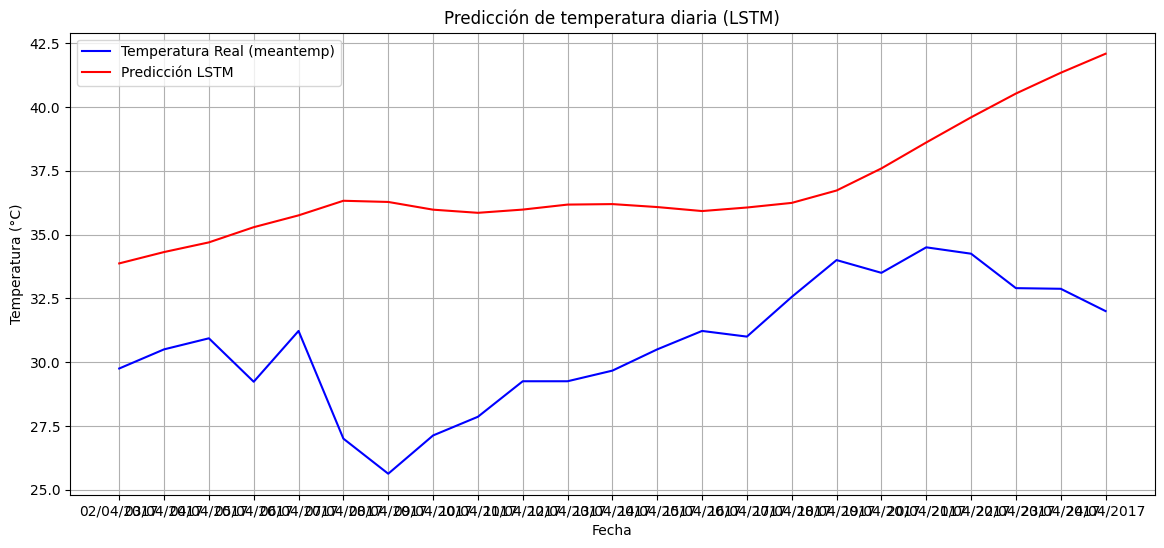

In [21]:
# Gráfico
plt.figure(figsize=(14, 6))
plt.plot(prediction_dates, real, label='Temperatura Real (meantemp)', color='blue')
plt.plot(prediction_dates, predictions, label='Predicción LSTM', color='red')
plt.title('Predicción de temperatura diaria (LSTM)')
plt.xlabel('Fecha')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
# Evaluación mensual con R2 y gráfico interactivo con Plotly

import plotly.graph_objects as go
from sklearn.metrics import r2_score

# Asegurar que los índices estén en formato datetime
real_demand.index = pd.to_datetime(real_demand.index, dayfirst=True)
predictions_series.index = pd.to_datetime(predictions_series.index, dayfirst=True)

# Calcular R² mensual
r_squared_monthly = []
for month, group in real_demand.groupby(real_demand.index.month):
    pred_for_month = predictions_series[group.index]
    r_squared = r2_score(group, pred_for_month)
    r_squared_monthly.append((month, r_squared))
    print(f'R² para el mes {month}: {r_squared:.4f}')

# 📍 Gráfico interactivo con Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x=real_demand.index, y=real_demand,
                         mode='lines', name='Temperatura Real',
                         line=dict(color='blue')))

fig.add_trace(go.Scatter(x=predictions_series.index, y=predictions_series,
                         mode='lines', name='Predicción LSTM',
                         line=dict(color='red')))

fig.update_layout(
    title='Predicción vs Real de Temperatura con LSTM',
    xaxis_title='Fecha',
    yaxis_title='Temperatura (°C)',
    legend_title='Leyenda',
    template='plotly_white'
)

fig.show()

# 🔢 Mostrar los R² mensuales
for month, r_squared in r_squared_monthly:
    print(f"R² para el mes {month}: {r_squared:.4f}")

R² para el mes 4: -6.5098


R² para el mes 4: -6.5098


El modelo LSTM utilizado para predecir la temperatura no logró ajustarse adecuadamente a los datos reales, como se observa en la discrepancia entre las curvas de predicción y los valores reales, especialmente durante la segunda mitad del mes. La línea de predicción presenta una tendencia creciente más suave y continua, mientras que la temperatura real muestra mayor variabilidad. Esta diferencia sugiere que el modelo no está capturando correctamente los patrones y fluctuaciones de la serie temporal.

Además, el valor de R^2 obtenido (-6.5098) indica un desempeño muy deficiente, ya que un valor negativo implica que el modelo predice peor que simplemente asumir un valor constante basado en el promedio. Esto puede deberse a un modelo mal ajustado, a un preprocesamiento inadecuado de los datos, o a una arquitectura demasiado simple.